# 001_Building Dataset

In [ ]:
%cd "/content/drive/MyDrive/Datasets/Image_Captioning_Dataset"
!ls

/content/drive/MyDrive/Datasets/Image_Captioning_Dataset
dataset.zip


In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

In [ ]:
!ls

dataset.zip  flickr8k


In [3]:
root_dir = "/content/drive/MyDrive/Datasets/Image_Captioning_Dataset/flickr8k"

In [4]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import spacy # for tokenizer (can use nltk as well)
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

spacy_eng = spacy.load("en")

In [5]:
class Vocabulary(object):
  def __init__(self, freq_threshold):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}
    self.stoi = {"<PAD>":0, "<SOS>":1, "<EOS>":2, "<UNK>":3}
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4
    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence):
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1
        if frequencies[word] == self.freq_threshold:
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1
  
  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text)
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text
    ]

In [6]:
class FDataset(Dataset):
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform = transform

    # Getting the image and captions
    self.imgs = self.df["image"]
    self.captions = self.df["caption"]

    # Initialize vocabulary and build a vocabulary
    self.vocab = Vocabulary(freq_threshold)
    self.vocab.build_vocabulary(self.captions.tolist())
    
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    caption = self.captions[index]
    img_id = self.imgs[index]
    img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
    
    if self.transform is not None:
      img = self.transform(img)
    
    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])

    return img, torch.tensor(numericalized_caption)

In [7]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

In [8]:
def get_loader(root_dir, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
  dataset = FDataset(root_dir, annotation_file, transform)
  # print(f'Length of dataset: {len(dataset)}')
  # print(f'Length of vocabulary: {len(dataset.vocab)}')
  pad_idx = dataset.vocab.stoi["<PAD>"]
  loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, pin_memory=pin_memory, collate_fn=MyCollate(pad_idx))
  return loader, dataset

In [9]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

dataloader, dataset = get_loader(root_dir+'/images', root_dir+'/captions.txt',transform=transform)

In [8]:
print(len(dataloader))
for idx, (imgs, captions) in enumerate(dataloader):
  print(imgs.shape)
  print(captions.shape)
  if idx == 2:
    break

1265
torch.Size([32, 3, 224, 224])
torch.Size([22, 32])
torch.Size([32, 3, 224, 224])
torch.Size([25, 32])
torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


Text(0.5, 1.0, 'A man is checking out an injured football player at a game .')

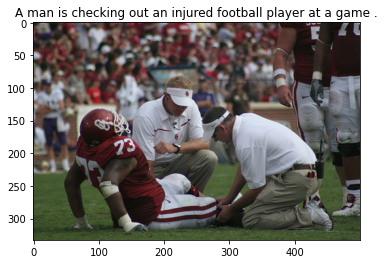

In [10]:
df = pd.read_csv(root_dir + '/captions.txt')
idx = np.random.randint(0,len(df))
img_id = df["image"][idx]
caption = df["caption"][idx]
img = Image.open(os.path.join(root_dir+'/images', img_id)).convert("RGB")
plt.imshow(img)
plt.title(f'{caption}')

# 002_Implementation of CNN and RNN

In [10]:
# Printing inception_v3 model

import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
  def __init__(self, embed_size, train_CNN=False):
    super(EncoderCNN, self).__init__()
    self.train_CNN = train_CNN
    self.inception = models.inception_v3(pretrained=True, aux_logits=False)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

  def forward(self, images):
    return self.inception(images)

In [11]:
model = EncoderCNN(100)
print(model)

EncoderCNN(
  (inception): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): Ba

In [12]:
images = torch.randn(64,3,224,224)
output = model(images)
print(output.shape)

torch.Size([64, 1000])


In [13]:
# Tweak the last layer of inception_v3 model
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
  def __init__(self, embed_size, train_CNN=False):
    super(EncoderCNN, self).__init__()
    self.train_CNN = train_CNN
    self.inception = models.inception_v3(pretrained=True, aux_logits=False)
    self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

  def forward(self, images):
    features = self.inception(images)

    for name, param in model.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
      else:
        param.requires_grad = self.train_CNN
    
    return self.dropout(self.relu(features))

In [14]:
# Testing EncoderCNN
X = torch.randn(64,3,299,299)
model = EncoderCNN(100)
print(model(X).shape)

torch.Size([64, 100])


In [17]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions))
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

In [18]:
class CNNtoRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(CNNtoRNN, self).__init__()
    self.encoderCNN = EncoderCNN(embed_size)
    self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
  
  def forward(self, images, captions):
    features = self.encoderCNN(images)
    outputs = self.decoderRNN(features, captions)
    return outputs

  def caption_image(self, image, vocabulary, max_length=50):
    result_caption = []
    with torch.no_grad():
      x = self.encoderCNN(image).unsqueeze(0)
      states = None
      for _ in range(max_length):
        hiddens, states = self.decoderRNN.lstm(x, states)
        output = self.decoderRNN.linear(hiddens.squeeze(0))
        predicted = output.argmax(1)

        result_caption.append(predicted.item())
        x = self.decoderRNN.embed(predicted).unsqueeze(0)
        if vocabulary.itos[predicted.item()] == "<EOS>":
          break
    return [vocabulary.itos[idx] for idx in result_caption]

In [19]:
output_root_dir = "/content/drive/MyDrive/Model_Outputs/Image_Captioning"
def save_checkpoint(state, filename=f"{output_root_dir}/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [84]:
# Let's test our test images
def test(model, device, dataset):
  transform = transforms.Compose([transforms.Resize((299,299)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
  model.eval()
  # dog.jpg, child.jpg, horse.png
  test_img = transform(Image.open(root_dir+'/test_images/horse.png').convert("RGB")).unsqueeze(0)
  output = model.caption_image(test_img.to(device), dataset.vocab)
  print("Predicted caption:" +  " ".join(model.caption_image(test_img.to(device), dataset.vocab)))
  
  img = test_img.squeeze(0).numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)

In [76]:
# Training
def train(epochs=1,validate=False,load_model=False,print_every=50):
  transform = transforms.Compose([transforms.Resize((356,356)),
                                  transforms.RandomCrop((299,299)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

  train_loader, dataset = get_loader(root_dir+'/images', root_dir+'/captions.txt',transform=transform)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  save_model = True

  # Hyperparameters
  embed_size = 256
  hidden_size = 256
  vocab_size = len(dataset.vocab)
  num_layers = 2
  learning_rate = 1e-4
  epochs = epochs

  step = 0

  # loss, model
  model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  
  if load_model:
    step = load_checkpoint(torch.load(f'{output_root_dir}/my_checkpoint.pth.tar'), model, optimizer)

  if not validate:
    model.train()
    for epoch in range(epochs):
      running_loss = 0.0
      for batch_idx, (images,captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        outputs = model(images, captions[:-1])
        # Outputs_shape: (seq_len, N, vocabulary_size)
        # Captions_shape:(seq_len, N)
        # Loss expects (N,100) -> (N)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        if batch_idx % print_every == 0:  
          print(f'Epoch: {epoch+1}/{epochs}\tBatch: {batch_idx+1}/{len(train_loader)}\tLoss:{loss.item()}')
        running_loss += loss.item()
        step+=1
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
      
      if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step
        }
        save_checkpoint(checkpoint)
      print(f'Epoch: {epoch+1}/{epochs}\t Average Loss:{loss.item()/len(train_loader)}')

  if validate:
    test(model, device, dataset)

In [30]:
train()

Epoch: 1/1	Batch: 1/1265	Loss:7.999505519866943
Epoch: 1/1	Batch: 2/1265	Loss:7.996272087097168
Epoch: 1/1	Batch: 3/1265	Loss:7.996264934539795
Epoch: 1/1	Batch: 4/1265	Loss:7.9926862716674805
Epoch: 1/1	Batch: 5/1265	Loss:7.989201545715332
Epoch: 1/1	Batch: 6/1265	Loss:7.9888200759887695
Epoch: 1/1	Batch: 7/1265	Loss:7.98477840423584
Epoch: 1/1	Batch: 8/1265	Loss:7.983618259429932
Epoch: 1/1	Batch: 9/1265	Loss:7.980829238891602
Epoch: 1/1	Batch: 10/1265	Loss:7.974627494812012
Epoch: 1/1	Batch: 11/1265	Loss:7.972375392913818
Epoch: 1/1	Batch: 12/1265	Loss:7.968323707580566
Epoch: 1/1	Batch: 13/1265	Loss:7.97198486328125
Epoch: 1/1	Batch: 14/1265	Loss:7.9654951095581055
Epoch: 1/1	Batch: 15/1265	Loss:7.962071418762207
Epoch: 1/1	Batch: 16/1265	Loss:7.9568190574646
Epoch: 1/1	Batch: 17/1265	Loss:7.956966876983643
Epoch: 1/1	Batch: 18/1265	Loss:7.9568939208984375
Epoch: 1/1	Batch: 19/1265	Loss:7.955079555511475
Epoch: 1/1	Batch: 20/1265	Loss:7.94879674911499
Epoch: 1/1	Batch: 21/1265	Loss

=> Loading checkpoint
Predicted caption:<SOS> a man in a black dog in a <UNK> . <EOS>


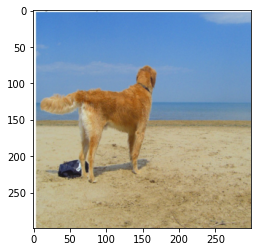

In [73]:
train(validate=True, load_model=True)

In [78]:
# Let's train the model for 20 epochs
train(epochs=20)

Epoch: 1/20	Batch: 1/1265	Loss:7.989255428314209
Epoch: 1/20	Batch: 51/1265	Loss:7.161660671234131
Epoch: 1/20	Batch: 101/1265	Loss:5.031692981719971
Epoch: 1/20	Batch: 151/1265	Loss:4.99207878112793
Epoch: 1/20	Batch: 201/1265	Loss:4.673764705657959
Epoch: 1/20	Batch: 251/1265	Loss:4.591545104980469
Epoch: 1/20	Batch: 301/1265	Loss:4.488711357116699
Epoch: 1/20	Batch: 351/1265	Loss:4.450832366943359
Epoch: 1/20	Batch: 401/1265	Loss:4.520262718200684
Epoch: 1/20	Batch: 451/1265	Loss:4.430238246917725
Epoch: 1/20	Batch: 501/1265	Loss:4.304133415222168
Epoch: 1/20	Batch: 551/1265	Loss:4.305709362030029
Epoch: 1/20	Batch: 601/1265	Loss:4.138065814971924
Epoch: 1/20	Batch: 651/1265	Loss:4.3914265632629395
Epoch: 1/20	Batch: 701/1265	Loss:4.171452045440674
Epoch: 1/20	Batch: 751/1265	Loss:4.346179485321045
Epoch: 1/20	Batch: 801/1265	Loss:4.227897644042969
Epoch: 1/20	Batch: 851/1265	Loss:4.022204399108887
Epoch: 1/20	Batch: 901/1265	Loss:4.1489152908325195
Epoch: 1/20	Batch: 951/1265	Loss:

KeyboardInterrupt: ignored

=> Loading checkpoint
Predicted caption:<SOS> a dog is running through the water . <EOS>


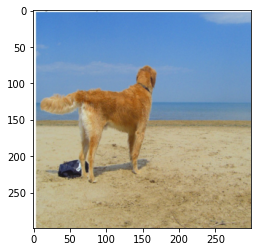

In [79]:
train(validate=True, load_model=True)

=> Loading checkpoint
Predicted caption:<SOS> a young boy in a red shirt is jumping on a swing . <EOS>


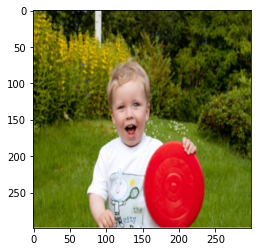

In [83]:
train(validate=True, load_model=True)

=> Loading checkpoint
Predicted caption:<SOS> two children are playing in a field . <EOS>


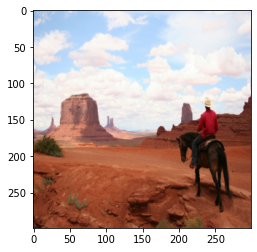

In [85]:
train(validate=True, load_model=True)   # Overfitted model